# DCC030 - Introdução a Computação Visual 2017/1
## Trabalho Prático 1 - Localização de palavras em texto

> Yuri Diego Santos Niitsuma  
> 2011039023



In [1]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print "OpenCV Version : %s " % cv2.__version__

OpenCV Version : 2.4.11 


Criação das pastas de exportação.

In [7]:
#  for output images
export_path = './export/'
if export_path[-1] != '/':
    export_path += '/'

# create export dir
if not os.path.isdir(export_path):
    os.mkdir(export_path)

### Implementação

Algumas funções na classe para abstrair as operações.

- `open_image`: carregar o arquivo contendo a imagem.
- `threshold`: faz o processo de limiarização.
- `blur`: remove ruído e efetua a operação morfológica com a matriz de cruz
- `draw_rectangles`: encontra os pontos de interesse e desenha retângulos vermelhos na imagem de saída.
- `save`: salva o arquivo com as caixas identificadas na pasta de exportação, o arquivo txt contendo as coordenadas das caixas também é salvo no local.
- `show_output`, `show_img`, e `show_original_img`: mostram as imagens de saída, tratamento e a original respecticamente.

In [8]:
class Image:
    """class Image for using in Jupyter with OpenCV 3.x.x"""
    name = str() # file name. ex: page1.jpg
    path_input = str() # input dir. ex: dados/
    path_output = str() # output data, if use save method
    color = str() # use 'black' or 'white' to detect points
    line_locations = list()
    img = None # image to do things
    img_original = None # original image
    img_output = None # output image with boxes

    def __init__(self, **kwargs):
        self.name = kwargs.get('name', 'input.jpg')
        self.path_input = kwargs.get('path_input', 'dados/')
        if len(self.path_input) > 0 and self.path_input[-1] != '/':
            self.path_input += '/'
        self.path_output = kwargs.get('path_output', 'export/')
        if len(self.path_output) > 0 and self.path_output[-1] != '/':
            self.path_output += '/'
        self.color = kwargs.get('color', 'black')

    def open_image(self): # Read image with opencv
        img_path = self.path_input + self.name
        self.img = cv2.imread(img_path)
        self.img_original = cv2.imread(img_path)
        if self.img is None:
            print('Arquivo não carregado, verifique se o nome do arquivo está correto')
            return False
        else:
            return True

    def threshold(self, div_value=180): # Convert to gray and make thresold of image
        # div_value: value between black and white
        img = self.img
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dummy, mask = cv2.threshold(img_gray, div_value, 255, cv2.THRESH_BINARY)
        img_bitwiseand = cv2.bitwise_and(img_gray, img_gray, mask=mask)
        if self.color == 'black':
            dummy, new_img = cv2.threshold(img_bitwiseand, div_value, 255, cv2.THRESH_BINARY_INV)
            # new_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
        elif self.color == 'white':
            dummy, new_img = cv2.threshold(img_bitwiseand, div_value, 255, cv2.THRESH_BINARY)
        else:
            print('Set black or white in beginning of file')
            return None
        self.img = new_img
        return self.img

    def blur(self, dim_size_x = 12, dim_size_y = 10, num_iter = 1): # Remove noise and blur image
        # http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
        # TODO: Make a away to get a mean of space between chars
        
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (dim_size_x, dim_size_y))
        # array([[0, 0, 1, 0, 0],
        #    [0, 0, 1, 0, 0],
        #    [1, 1, 1, 1, 1],
        #    [0, 0, 1, 0, 0],
        #    [0, 0, 1, 0, 0]], dtype=uint8)
        
        self.img = cv2.dilate(self.img, kernel, iterations=num_iter)
        return self.img

    def draw_rectangles(self, w_max=15, h_max=15): # draw rectangles with boxes on detect pixels
        # for cv 3.x.x return 3 elements
        # cv 2.x.x return 2
        image, contours, hierarchy = cv2.findContours(self.img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

        self.img_output = self.img_original.copy()

        self.line_locations = list()
        self.line_locations.append('x\t\ty\t\tw\t\th\n')

        count = 1
        for contour in contours:
            line = [x, y, w, h] = cv2.boundingRect(contour)

            if w < w_max and h < h_max: # false points?
                continue

            string = ''
            for value in line:
                string += str(value)
                string += '\t\t' if value < 1000 else '\t'
            string += '\n'

            self.line_locations.append(string)

            # draw rectangle around contour on original image
            cv2.rectangle(self.img_output, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
            count = count + 1
        
        print('Get ' + str(count - 1) + ' box of interest')
        return self.img_output

    def save(self): # save on file
        text_file = open(self.path_output + self.name + '.txt', 'w')
        if text_file is not None:
            for line in self.line_locations:
                text_file.write(line)
            text_file.close()
        return cv2.imwrite(self.path_output + self.name, self.img_output)

    def print_on_notebook(self, x=20, y=20, img=None):
        plt.figure(figsize=(x,y))
        plt.imshow(img)
        plt.show()
        
    def show_output(self, x=20, y=20):
        self.print_on_notebook(x=x, y=y, img=self.img_output)
        
    def show_img(self, x=20, y=20):
        self.print_on_notebook(x=x, y=y, img=self.img)
    
    def show_original_img(self, x=20, y=20):
        self.print_on_notebook(x=x, y=y, img=self.img_original)

### Testes

Seguem testes nos arquivos **page1.jpg** e **page2.jpg**.

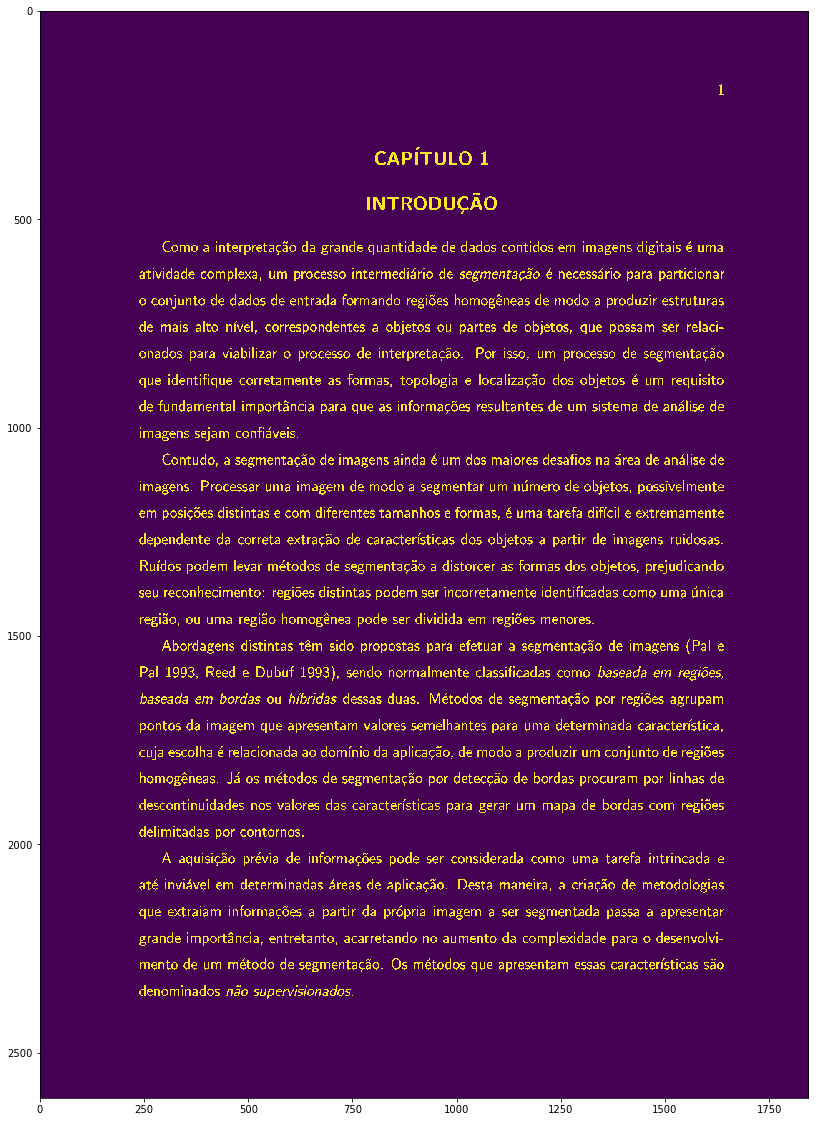

In [9]:
img = Image(name='page1.jpg')
if not img.open_image():
    raise Exception('failed to open file')
img.threshold()
img.show_img()

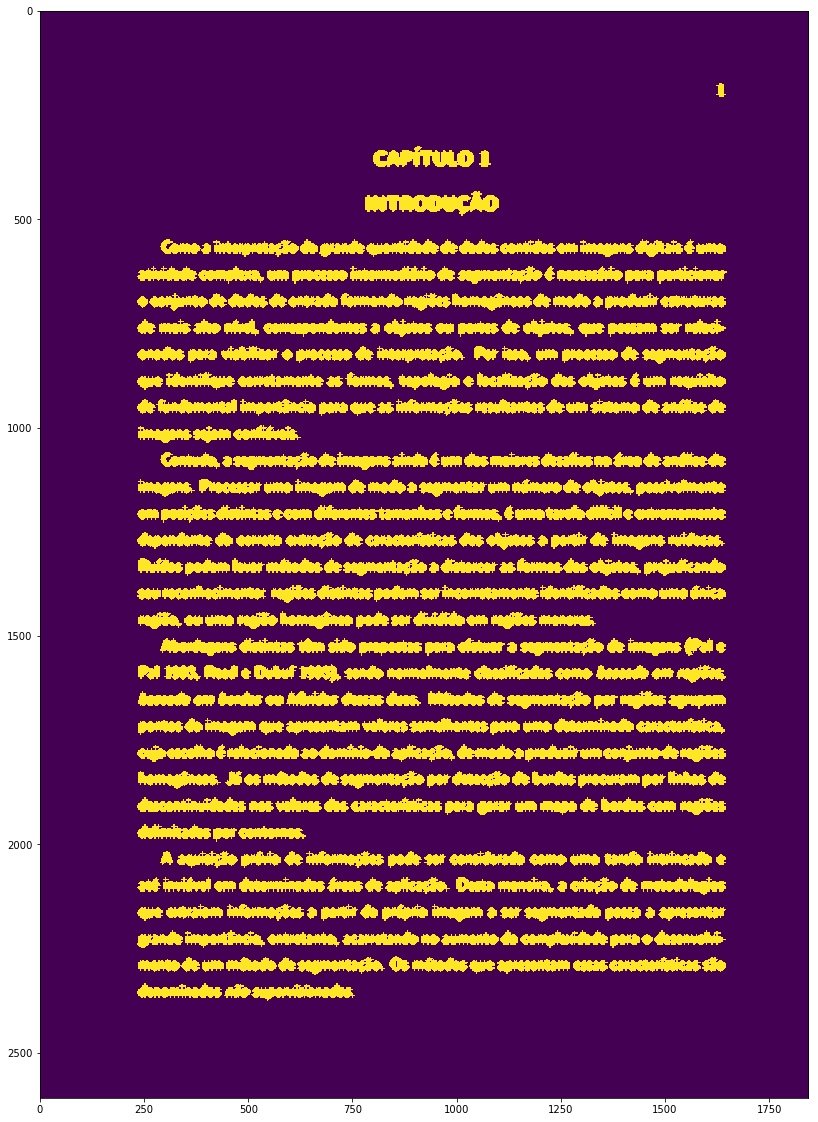

In [10]:
img.blur()
img.show_img()

In [11]:
img.draw_rectangles()
img.show_output()

ValueError: need more than 2 values to unpack

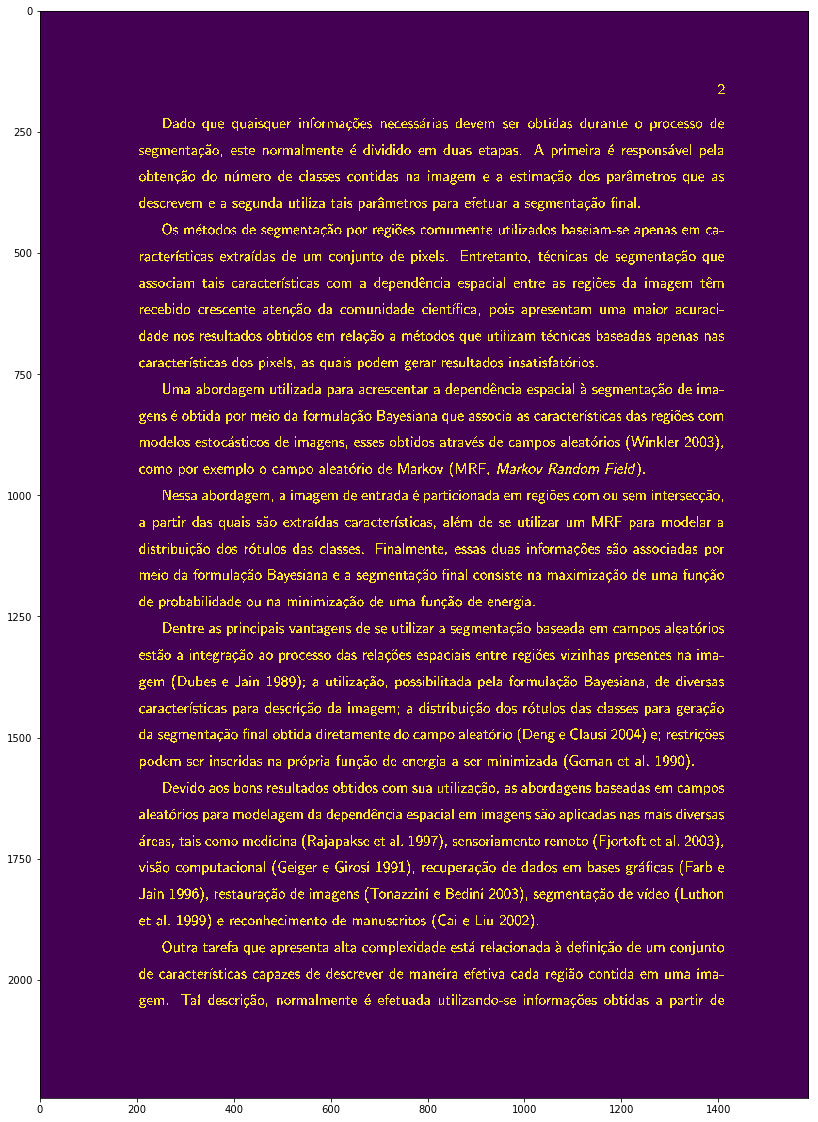

In [7]:
img2 = Image(name='page2.jpg')
if not img2.open_image():
    raise Exception('failed to open file')
img2.threshold()
img2.show_img()

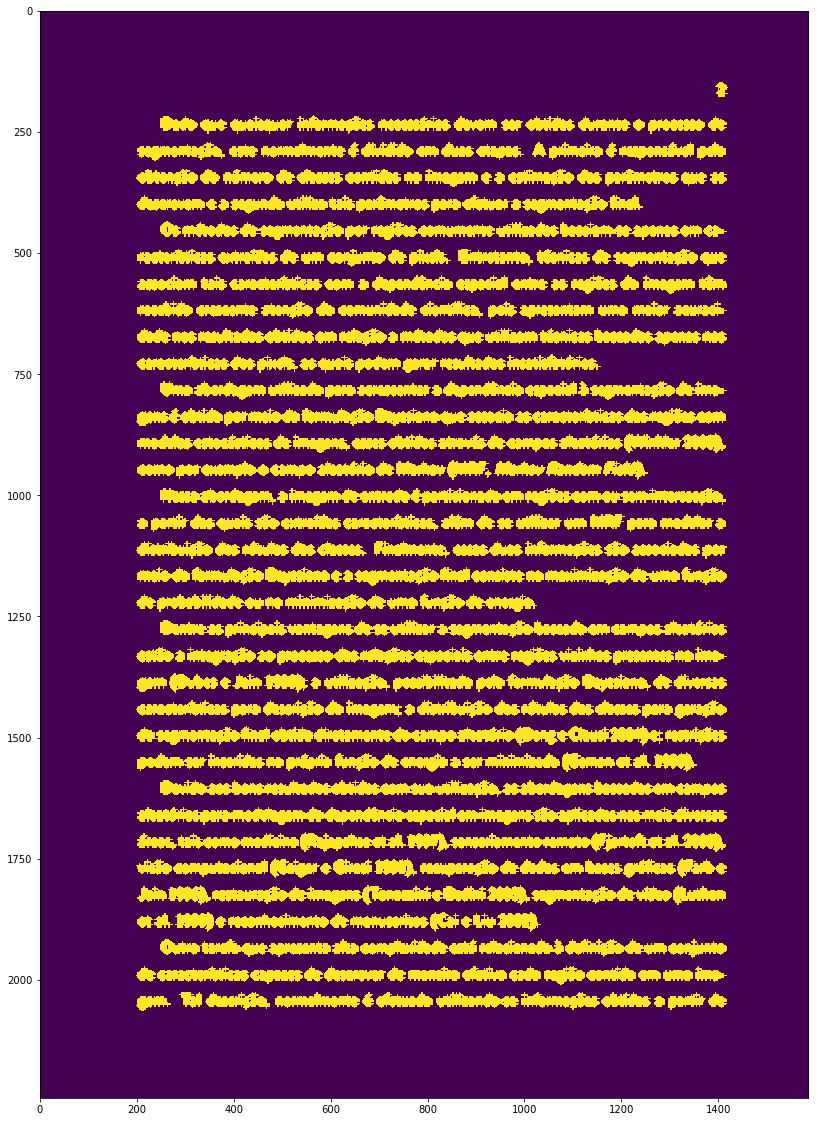

In [8]:
img2.blur()
img2.show_img()

Get 347 box of interest


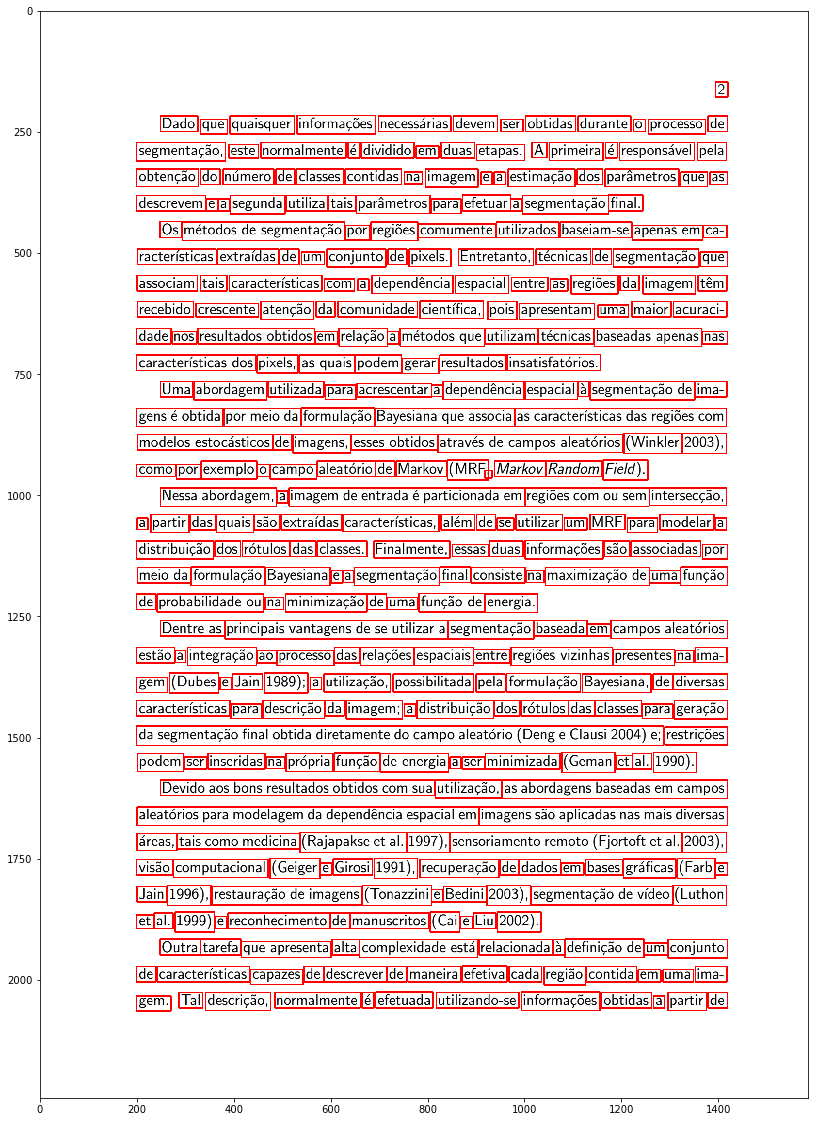

In [9]:
img2.draw_rectangles()
img2.show_output()

### Exportar

Caso deseje salvar o arquivo, utilize o método `.save`. Por padrão será exportado pra pasta **export/**.
Arquivo **.txt**, contendo todas as coordenadas das caixas também é salvo nesta pasta.

In [228]:
img.save()
img2.save()

True